##### In this notebook, we will train a single tuned Light Gradient boosting model on the whole Train and Validation dataset.
##### The trained model will then be serialized using pickling, which will then be used to make forecasts for the month of April 2023.

In [1]:
import time
import warnings
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

seed=42

In [2]:
top_TD_GH_by_district = np.array(
    pl.scan_parquet("../datasets/19_model/train.zstd")
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').le(20))
    .select('GEOHASH')
    .collect(streaming=True)
    .to_series()
    .to_list()
    # .to_pandas()
    # .to_excel("datasets/18_Viz/top_10_td_gh_district.xlsx", index=False)
)

len(top_TD_GH_by_district)

720

In [3]:
X_full = (
    pl.concat([
        (
            pl.read_parquet("../datasets/19_model/train.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
        ),
        (
            pl.read_parquet("../datasets/19_model/valid.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
        )
    ], how='vertical')
    .with_columns(pl.col(['GEOHASH', 'DISTRICT']).cast(pl.Utf8).cast(pl.Categorical))
    .sort(['DATE_TIME', 'GEOHASH'])
    .drop('NUMBER_OF_VEHICLES')
    .to_pandas()
    .set_index('DATE_TIME')
)

X_full.head()

,GEOHASH,DISTRICT,LOCATION_TYPE,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,HOLIDAY_NAME,HOLIDAY_TYPE,SCHOOL_HOLIDAY_TYPE,HIGHWAY_TRNSPRT_PSNGRS,...,HUMIDITY,PRCP,WINDSPEED,WTHR_CAT,TD_LAG1,TD_LAG24,TD_LAG168,PRCP_LAG1,PRCP_LAG2,PRCP_LAG3
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01,sxk90n,Bahçelievler,avenue,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,84,0.0,22.9,normal,192,192,192,0.0,0.0,0.0
2020-01-01,sxk3pn,Küçükçekmece,avenue,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,84,0.0,22.9,normal,185,185,185,0.0,0.0,0.0
2020-01-01,sxkcd0,Çekmeköy,street,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,88,0.0,15.6,normal,32,32,32,0.0,0.0,0.0
2020-01-01,sxk97t,Beyoğlu,other,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,87,0.0,16.6,normal,40,40,40,0.0,0.0,0.0
2020-01-01,sxk3w7,Başakşehir,street,627933,692729,1017034,New Year's Day,National holiday,Christmas holidays,15430,...,84,0.0,22.9,normal,122,122,122,0.0,0.0,0.0


In [4]:
y_full = (
    pl.concat([
        (
            pl.read_parquet("../datasets/19_model/train.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
        ),
        (
            pl.read_parquet("../datasets/19_model/valid.zstd")
            .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
        )
    ], how='vertical')
    .with_columns(pl.col(['GEOHASH', 'DISTRICT']).cast(pl.Utf8).cast(pl.Categorical))
    .sort(['DATE_TIME', 'GEOHASH'])
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

y_full.head()

,NUMBER_OF_VEHICLES
DATE_TIME,
2020-01-01,192
2020-01-01,185
2020-01-01,32
2020-01-01,40
2020-01-01,122


In [5]:
print(X_full.shape)
print(y_full.shape)

(20494080, 35)
(20494080, 1)


In [6]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20494080 entries, 2020-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 35 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   GEOHASH                     category
 1   DISTRICT                    category
 2   LOCATION_TYPE               category
 3   CITIZEN_RETURN              uint32  
 4   CITIZEN_ARRIVAL             uint32  
 5   TOURIST_ARRIVAL             uint32  
 6   HOLIDAY_NAME                category
 7   HOLIDAY_TYPE                category
 8   SCHOOL_HOLIDAY_TYPE         category
 9   HIGHWAY_TRNSPRT_PSNGRS      uint32  
 10  SEA_TRNSPRT_PSNGRS          uint32  
 11  RAIL_TRNSPRT_PSNGRS         uint32  
 12  IS_COVID_RESTRICTION        bool    
 13  FOOTBALL_STADIUM_STATUS     int8    
 14  NEARBY_LANDMARKS_CNT        uint8   
 15  NEARBY_PARKING_CAPACITY     uint16  
 16  NEARBY_TAXI_STND_CNT        uint8   
 17  NEARBY_MINIBUS_STOPS_CNT    uint8   
 18  NEARBY_F

In [7]:
cat_cols = [col for col in X_full.columns if X_full[col].dtype=='category']
time_cols = ["month", "day_of_month", "hour", "day_of_week"] #excluding year

print('String columns:', cat_cols)
print('Time columns:', time_cols)

# Extract date time features
dt_feats=DatetimeFeatures(variables='index', features_to_extract = ["year", "month", "day_of_month", "hour", "day_of_week"])

# Encode categorical columns with numbers.
ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_cols)

# Convert time features such as day, month, hour and day of week to cyclical features to maintain cyclicity.
cf_encoder=CyclicalFeatures(variables=time_cols, drop_original=True)


#Creating encoder pipeline
encoders = make_pipeline(
    (dt_feats), # Extract date time features
    (ord_encoder), # Ordinal Encoder
    (cf_encoder), # Cyclical Feature
)

String columns: ['GEOHASH', 'DISTRICT', 'LOCATION_TYPE', 'HOLIDAY_NAME', 'HOLIDAY_TYPE', 'SCHOOL_HOLIDAY_TYPE', 'WTHR_CAT']
Time columns: ['month', 'day_of_month', 'hour', 'day_of_week']


In [8]:
# LGBM
lgbm_params = {'n_estimators': 266, 
                'num_leaves': 87,
                'colsample_bytree': 0.676,
                'learning_rate': 0.0223, 
                'max_depth': 6, 
                'reg_alpha': 2.3, 
                'reg_lambda': 0.011, 
                'min_child_weight': 0.0017}

lgbm=LGBMRegressor(**lgbm_params, n_jobs=-1, random_state=seed)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (lgbm) #LGBM
)

print("Pipeline Created!")

Pipeline Created!


In [9]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/
class BlockingTimeSeriesSplit():
    """
    Class to that will return indices of each split for Cross Validation.
    """
    def __init__(self, n_splits: int):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.9 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

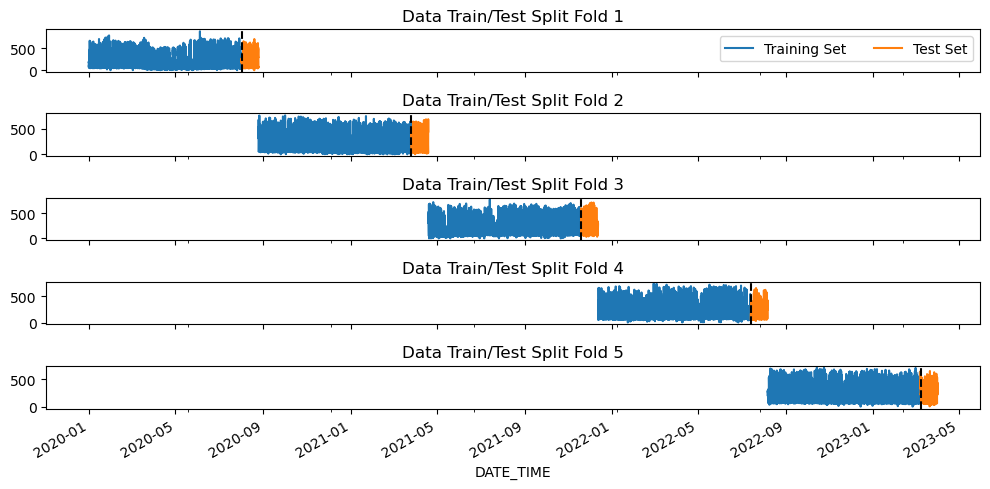

In [10]:
# choosing only a sample of dataset
sample = (
    pd.concat([X_full, y_full], axis=1)
    .query("GEOHASH in ('sxk90n', 'sxk3pn')")
)

N=2
H=24

#Visualizing how the cross validation will be done
n_split = 5

sample_tss = BlockingTimeSeriesSplit(n_splits=n_split)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split), sharex=True, tight_layout=True)

fold = 0
for train_idx, val_idx in sample_tss.split(sample):
    train_cv = sample.iloc[train_idx]
    test_cv = sample.iloc[val_idx]
    
    train_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold + 1}', legend=False)
    
    test_cv.plot(y='NUMBER_OF_VEHICLES', ax=axs[fold], label='Test Set', legend=False)
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
    fold += 1

axs.flatten()[0].legend(ncol=2, loc='upper right');

In [11]:
def plot_cv_results(pipeline):
    
    feat_scores=pipeline.steps[-1][-1].feature_importances_
    feat_names=pipeline.steps[-1][-1].feature_name_

    #Creating a dataframe for feature importance
    feat_imp_df = (
        pd.DataFrame({'features' : feat_names,'importance' : np.abs(np.round(feat_scores, 3))})
        .set_index('features').sort_values('importance')
    )
    
    #Print Features with Low Importance
    print("Features with Low Importance:")
    print(np.sort(feat_imp_df.query("importance<=0.001").index))
    
    #Plot
    ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))
    ax.bar_label(ax.containers[0], fontsize=13, padding=3);
    ax.legend().remove()
    ax.set_title("Feature Importance")
    
    plt.show();

In [12]:
tss = BlockingTimeSeriesSplit(n_splits=5)

In [13]:
%%time
rmse_values = []

count = 1
# Loop through the folds
print("Cross Validating.....")
print()

# start timer
loop_time = time.time()

for train_index, test_index in tss.split(X_full, y_full):

    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]

    # Fit the model on the train data
    pipeline.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred = np.round(pipeline.predict(X_test_cv))

    # Calculate the mean squared error
    rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

    print(f"cv #{count}: RMSE = {rmse:.3f} | Time taken: {(time.time() - loop_time)/60:.2f} min")

    rmse_values.append(rmse)
    count += 1
    loop_time = time.time()
    
# Print the average MSE over all folds
print()
print(f"Average RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")

Cross Validating.....

cv #1: RMSE = 29.156 | Time taken: 2.26 min
cv #2: RMSE = 26.359 | Time taken: 2.32 min
cv #3: RMSE = 30.995 | Time taken: 2.27 min
cv #4: RMSE = 29.975 | Time taken: 2.32 min
cv #5: RMSE = 36.445 | Time taken: 2.42 min

Average RMSE: 30.586 ± 3.31
Wall time: 11min 35s


Features with Low Importance:
['FOOTBALL_STADIUM_STATUS' 'IS_COVID_RESTRICTION' 'NEARBY_FERRIES_CNT']


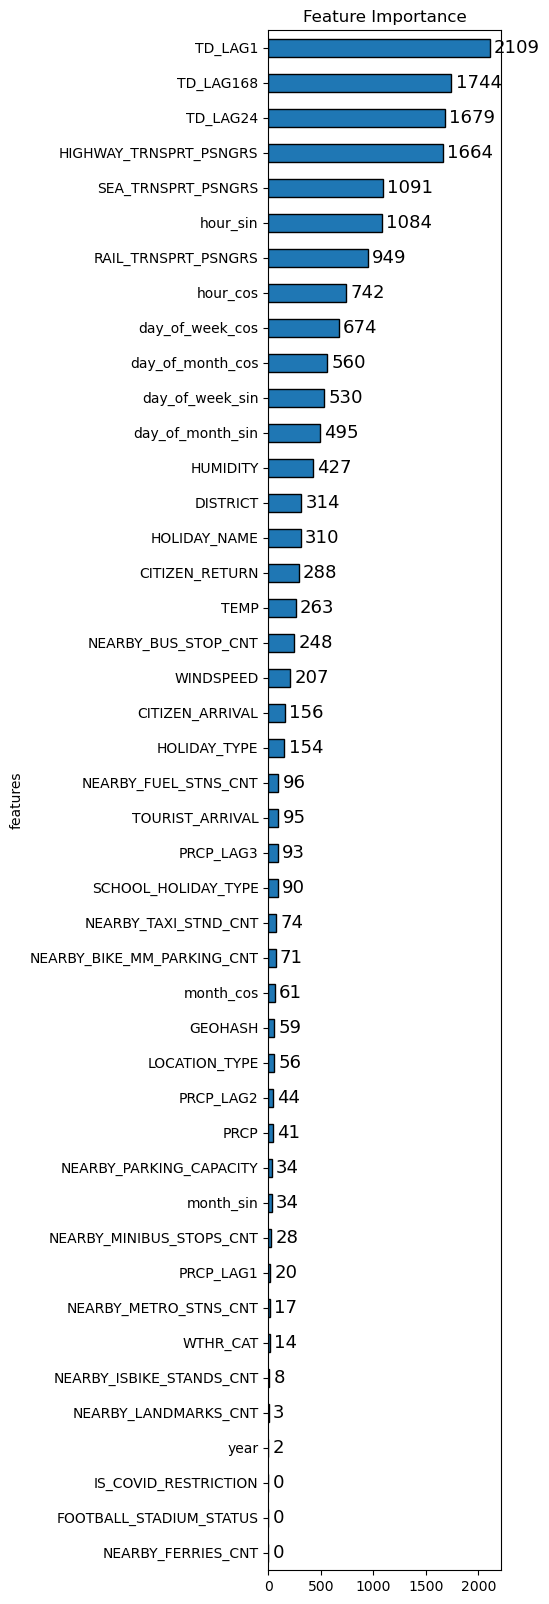

In [14]:
plot_cv_results(pipeline=pipeline)

In [15]:
import pickle

#Serializing the trained final model
with open("final_model.pkl", "wb") as w:
    pickle.dump(pipeline, w)